<a href="https://colab.research.google.com/github/Voztok94/Extra-Credit/blob/main/ExtraCredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install face_recognition opencv-python-headless

import face_recognition
import os
import cv2
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow  # For displaying images in Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=c2dc8e2b010e7cdeef9db9d472db7ad162c7ef1f19dce9bbaffa837f220dcc60
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


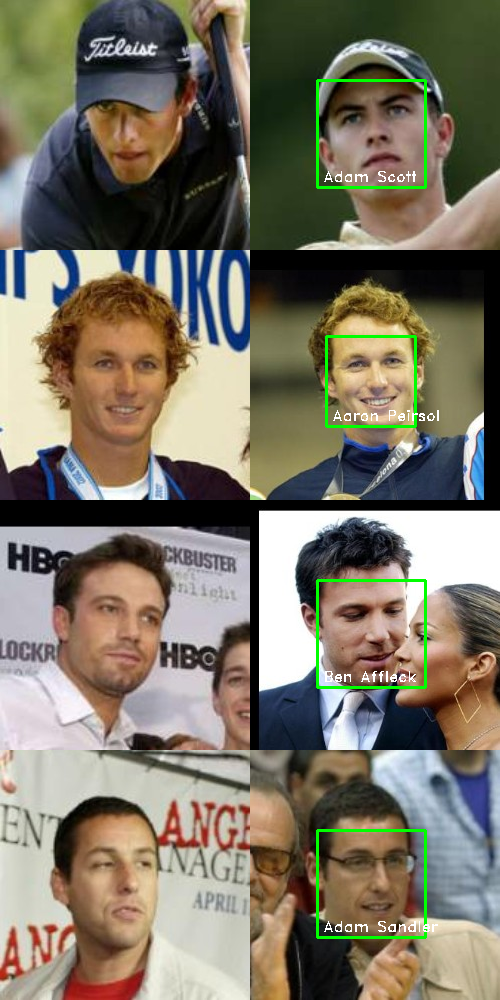

The following are unidentified images:
Zydrunas_Ilgauskas_0001.jpg

The following people are missing:
Donald Trump.jpg
Mike Pence.jpg


In [3]:
def compare_faces(known_faces_folder, unknown_faces_folder):
    """Compares faces in two folders and returns a dictionary of matches."""

    # Load known face encodings
    known_encodings = {}
    for filename in os.listdir(known_faces_folder):
        known_image_path = os.path.join(known_faces_folder, filename)
        image = face_recognition.load_image_file(known_image_path)
        encoding = face_recognition.face_encodings(image)
        if encoding:
            known_encodings[filename] = encoding[0]

    # Find matches between known and unknown faces
    matches = {}
    unmatched_unknowns = []
    matched_knowns = set()

    for filename in os.listdir(unknown_faces_folder):
        unknown_image_path = os.path.join(unknown_faces_folder, filename)
        image = face_recognition.load_image_file(unknown_image_path)
        unknown_encoding = face_recognition.face_encodings(image)
        if not unknown_encoding:
            continue  # Skip if no faces found in the image

        match_found = False
        for known_name, known_encoding in known_encodings.items():
            result = face_recognition.compare_faces([known_encoding], unknown_encoding[0], tolerance=0.65)
            if result[0]:
                matches[filename] = known_name
                matched_knowns.add(known_name)
                match_found = True
                break

        if not match_found:
            unmatched_unknowns.append(filename)

    # Identify missing known people
    missing_knowns = set(known_encodings.keys()) - matched_knowns

    return matches, unmatched_unknowns, missing_knowns

def stack_images_vertically_with_boxes(known_faces_folder, unknown_faces_folder, matches):
    """Stacks all matched images in a single window vertically with boxes around unknown faces."""

    stacked_images = []

    for unknown_file, known_name in matches.items():
        unknown_image_path = os.path.join(unknown_faces_folder, unknown_file)
        known_image_path = os.path.join(known_faces_folder, known_name)

        # Load images using OpenCV
        unknown_img = cv2.imread(unknown_image_path)
        known_img = cv2.imread(known_image_path)

        # Detect face locations in the unknown image
        face_locations = face_recognition.face_locations(unknown_img)

        # Iterate over face locations and draw rectangle and label for each face
        for (top, right, bottom, left) in face_locations:
            cv2.rectangle(unknown_img, (left, top), (right, bottom), (0, 255, 0), 2)
            # Remove the .jpg extension from the name
            name_without_extension = os.path.splitext(known_name)[0]
            cv2.putText(unknown_img, name_without_extension, (left + 6, bottom - 6), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)

        # Resize images to the same height for consistent stacking
        height = max(known_img.shape[0], unknown_img.shape[0])
        unknown_img = cv2.resize(unknown_img, (int(unknown_img.shape[1] * height / unknown_img.shape[0]), height))
        known_img = cv2.resize(known_img, (int(known_img.shape[1] * height / known_img.shape[0]), height))

        # Create a new image with both images stacked horizontally
        total_width = unknown_img.shape[1] + known_img.shape[1]
        combined_image = np.zeros((height, total_width, 3), dtype=np.uint8)

        # Paste known image on the left and unknown image on the right
        combined_image[:known_img.shape[0], :known_img.shape[1]] = known_img
        combined_image[:unknown_img.shape[0], known_img.shape[1]:] = unknown_img

        # Add the combined image to the list of stacked images
        stacked_images.append(combined_image)

    # Combine all pairs vertically into one single image
    if stacked_images:
        total_height = sum(image.shape[0] for image in stacked_images)
        max_width = max(image.shape[1] for image in stacked_images)
        final_image = np.zeros((total_height, max_width, 3), dtype=np.uint8)

        # Paste each combined image below the previous one
        y_offset = 0
        for img in stacked_images:
            final_image[y_offset:y_offset + img.shape[0], :img.shape[1]] = img
            y_offset += img.shape[0]

        # Display the final image with all matches stacked vertically
        cv2_imshow(final_image)

if __name__ == "__main__":
    known_folder = '/content/Drive/MyDrive/Faces/known'
    unknown_folder = '/content/Drive/MyDrive/Faces/unknown'

    matches, unmatched_unknowns, missing_knowns = compare_faces(known_folder, unknown_folder)

    if matches:
        stack_images_vertically_with_boxes(known_folder, unknown_folder, matches)

    # Display the results for unmatched and missing faces
    if unmatched_unknowns:
        print("The following are unidentified images:")
        for img in unmatched_unknowns:
            print(img)

    if missing_knowns:
        print("\nThe following people are missing:")
        for person in missing_knowns:
            print(person)